In [1]:
#IMPORT ALL NECESSARY LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
#PROVIDING PATH FOR DATASET
input_dir = r"E:/projects/smsSpamDetection/spam.csv"

#READING THE FILE PRESENT IN THE PROVIDED DATASET
df = pd.read_csv(input_dir,encoding='latin-1')
#PRINTING THE HEAD OF THE DATASET: PRINTING FIRST 5 RECORDS
df.head().T

,0,1,2,3,4
v1,ham,ham,spam,ham,ham
v2,"Go until jurong point, crazy.. Available only ...",Ok lar... Joking wif u oni...,Free entry in 2 a wkly comp to win FA Cup fina...,U dun say so early hor... U c already then say...,"Nah I don't think he goes to usf, he lives aro..."
Unnamed: 2,NaN,NaN,NaN,NaN,NaN
Unnamed: 3,NaN,NaN,NaN,NaN,NaN
Unnamed: 4,NaN,NaN,NaN,NaN,NaN


In [3]:
#PRINTING INFORMATION ABOUT THE DATASET - SHOWS DATA TYPE, NULL COUNTS AND MEMORY USAGE
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5574 non-null   object
 1   v2          5574 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.9+ KB


In [4]:
#DISPLAYS DESCRIPTIVE STATISTICS LIKE: COUNT, UNIQUE, TOP, FREQUENCY
df.describe().T

,count,unique,top,freq
v1,5574,2,ham,4825
v2,5574,5171,"Sorry, I'll call later",30
Unnamed: 2,50,43,"bt not his girlfrnd... G o o d n i g h t . . .@""",3
Unnamed: 3,12,10,"MK17 92H. 450Ppw 16""",2
Unnamed: 4,6,5,"GNT:-)""",2


In [5]:
#RENAMING THE COLUMNS: RENAMING V1 WITH LABEL AND V2 WITH MESSAGE
df = df[['v1','v2']]
df.columns = ['label','message']
df.head().T

,0,1,2,3,4
label,ham,ham,spam,ham,ham
message,"Go until jurong point, crazy.. Available only ...",Ok lar... Joking wif u oni...,Free entry in 2 a wkly comp to win FA Cup fina...,U dun say so early hor... U c already then say...,"Nah I don't think he goes to usf, he lives aro..."


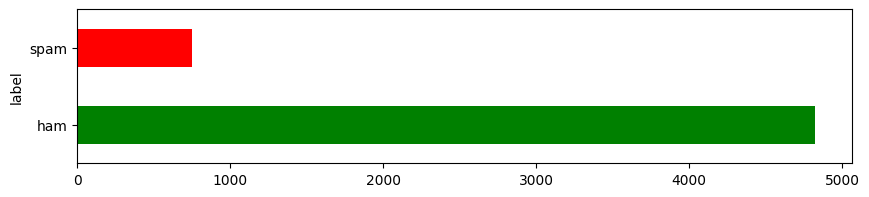

In [6]:
#VISUALISE THE DISTRIBUTION OF SPAM AND HAM(NOT SPAM) MESSAGES
plt.figure(figsize=(10, 2))
df['label'].value_counts().plot(kind='barh',color=['green','red'])
plt.title = 'Distribution of Spam vs Ham'
plt.xlabel = 'Label'
plt.show()

In [7]:
#TEXT PREPROCESSING STEPS
'''
    CONVERT TEXT TO LOWERCASE
    REPLACES PHONE NUMBER WITH URLS
    REMOVES PUNCTUATION
    REMOVES STOPWORDS
    APPLIES LEMMATISATION'''

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d{10}', 'phonenumber', text)
    text = re.sub(r'http\S+|www\S+', 'url', text)

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove punctuation
    words = text.split()
    lemmatized = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(lemmatized)


[nltk_data] Downloading package stopwords to D:\python312\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\python312\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to D:\python312\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [8]:
#APPLY THE PREPROCESSING
df['processed_message'] = df['message'].apply(preprocess_text)
df.head().T

,0,1,2,3,4
label,ham,ham,spam,ham,ham
message,"Go until jurong point, crazy.. Available only ...",Ok lar... Joking wif u oni...,Free entry in 2 a wkly comp to win FA Cup fina...,U dun say so early hor... U c already then say...,"Nah I don't think he goes to usf, he lives aro..."
processed_message,go jurong point crazy available bugis n great ...,ok lar joking wif u oni,free entry 2 wkly comp win fa cup final tkts 2...,u dun say early hor u c already say,nah dont think go usf life around though


In [9]:
X = df['processed_message']
y = df['label']

#SPLIT THE DATASET INTO TEST DATA AND TRAINING DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
#CONVERT TEXT MESSAGES INTO NUMERICAL FORM USING TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Accuracy: 0.9650224215246637
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       941
        spam       1.00      0.78      0.87       174

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.96      1115



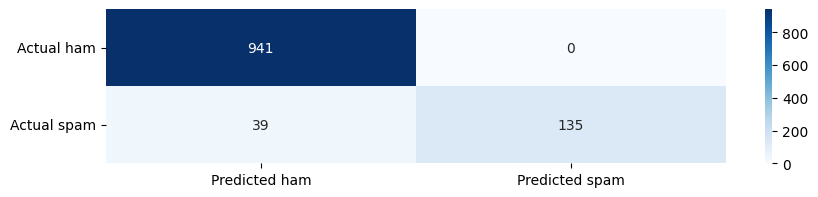

In [11]:
#MODEL TRAINING
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

y_pred = nb_classifier.predict(X_test_tfidf)

#PRINTING THE TEST ACCURACY (MODEL EVALUATION)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

#DRAWING THE CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted ham', 'Predicted spam'],
            yticklabels=['Actual ham', 'Actual spam'])
plt.show()

Best Parameters: {'alpha': 0.1, 'fit_prior': True}
Best Cross-Validation Score: 0.9508943277430328
Test Accuracy: 0.9865470852017937
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       941
        spam       0.99      0.92      0.96       174

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



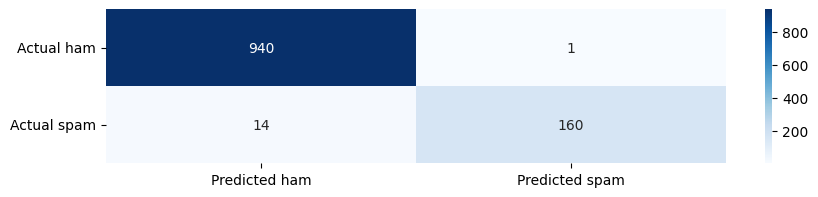

In [12]:
# TUNING PARAMETERS
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False]
}

#USING GRIDSEARCHCV FOR TUNING THE MODEL
grid_search = GridSearchCV(estimator=nb_classifier,
                           param_grid=param_grid, cv=5,
                           scoring='f1_macro', n_jobs=-1)


#FIT THE GRIDSEARCHCV TO THE TRAINING DATA
grid_search.fit(X_train_tfidf, y_train)

#GET THE BEST PARAMETERS AND BEST SCORE
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

#EVALUATE THE BEST MODEL ON THE TEST SET
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

#PLOT CONFUSION MATRIX
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted ham', 'Predicted spam'],
            yticklabels=['Actual ham', 'Actual spam'])
plt.show()

In [13]:
#SAVE VECTORIZER & MODEL
import joblib

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(best_model,   'spam_classifier_model.pkl')
print("✅ Saved vectorizer and model to disk.")

#SINGLE‑INPUT PREDICTION
print("\n--- Single SMS Prediction ---")
msg = input("Enter an SMS message:\n")
proc = preprocess_text(msg)
vec  = vectorizer.transform([proc])
pred = best_model.predict(vec)[0]
label = "🚨 SPAM" if pred=='spam' else "✅ HAM  -- SAFE MESSAGE/NOT SPAM"
print(f"\nMessage:\n  {msg}\nPrediction:\n  {label}")

✅ Saved vectorizer and model to disk.

--- Single SMS Prediction ---


Enter an SMS message:
 download the app and enjoy all features



Message:
  download the app and enjoy all features
Prediction:
  🚨 SPAM


In [15]:
joblib.dump(best_model, "spam_classifier_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']